In [ ]:
import pandas as pd
import numpy as np
from faker import Faker

fake = Faker()
num_rows = 1_000_000  # 1 million rows
batch_size = 100_000  # write in chunks to avoid memory issues

output_file = "/lakehouse/default/Files/transactions.csv"

# Open file and write header first
with open(output_file, "w") as f:
    f.write("CustomerName,Email,CardNumber,Age,Amount,Country,TransactionDate\n")

# Generate in batches
for _ in range(num_rows // batch_size):
    data = {
        "CustomerName": [fake.name() for _ in range(batch_size)],
        "Email": [fake.email() for _ in range(batch_size)],
        "CardNumber": [fake.credit_card_number() for _ in range(batch_size)],
        "Age": np.random.randint(18, 80, batch_size),
        "Amount": np.round(np.random.uniform(10, 5000, batch_size), 2),
        "Country": [fake.country() for _ in range(batch_size)],
        "TransactionDate": [fake.date_time_between(start_date='-2y', end_date='now').isoformat() for _ in range(batch_size)]
    }

    df = pd.DataFrame(data)
    df.to_csv(output_file, mode='a', header=False, index=False)

print("✅ 1 million rows generated and saved to transactions.csv")

StatementMeta(, dcbd4c3a-06a8-4d4c-ba7a-460466f70e81, 5, Finished, Available, Finished)

✅ 1 million rows generated and saved to transactions.csv


In [ ]:
from pyspark.sql.functions import col, sha2, concat_ws, rand, round as spark_round
import pandas as pd
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import Metadata
from sklearn.preprocessing import MinMaxScaler

# ----------------------------
# LOAD RAW DATA
# ----------------------------
raw_df = spark.read.csv("Files/transactions.csv", header=True, inferSchema=True)

# Example schema:
# CustomerName | Email | CardNumber | Age | Amount | Country | TransactionDate

# --------------------------------------------------------------
# MASK DIRECT IDENTIFIERS (HASHING)
# --------------------------------------------------------------
masked_df = (
    raw_df
    .withColumn("CustomerHash", sha2(concat_ws(":", col("CustomerName"), col("Email")), 256))
    .drop("CustomerName", "Email", "CardNumber")   # Remove PII
)

# --------------------------------------------------------------
# SAMPLE DATA TO PANDAS
# --------------------------------------------------------------
sample_data = masked_df.limit(200_000).toPandas()

# --------------------------------------------------------------
# DROP UNIQUE IDENTIFIERS
# --------------------------------------------------------------
if "CustomerHash" in sample_data.columns:
    sample_data = sample_data.drop(columns=["CustomerHash"])

# --------------------------------------------------------------
# HANDLE HIGH-CARDINALITY COLUMNS
# --------------------------------------------------------------
# Reduce rare countries to 'Other'
if 'Country' in sample_data.columns:
    value_counts = sample_data['Country'].value_counts()
    rare_countries = value_counts[value_counts < 50].index
    sample_data['Country'] = sample_data['Country'].replace(rare_countries, 'Other')

# Extract date features
if 'TransactionDate' in sample_data.columns:
    sample_data['TransactionDate'] = pd.to_datetime(sample_data['TransactionDate'], errors='coerce')
    sample_data['DayOfWeek'] = sample_data['TransactionDate'].dt.dayofweek
    sample_data['Month'] = sample_data['TransactionDate'].dt.month
    sample_data = sample_data.drop(columns=['TransactionDate'])

# --------------------------------------------------------------
# NORMALIZE NUMERIC COLUMNS (Age, Amount)
# --------------------------------------------------------------
scalers = {}
for col_name in ['Age', 'Amount']:
    if col_name in sample_data.columns:
        scaler = MinMaxScaler()
        sample_data[col_name] = scaler.fit_transform(sample_data[[col_name]])
        scalers[col_name] = scaler  # store scaler for inverse transformation

# --------------------------------------------------------------
# DETECT AND UPDATE METADATA
# --------------------------------------------------------------
metadata = Metadata()
metadata.detect_table_from_dataframe(
    table_name="my_table",
    data=sample_data
)

# Ensure correct data types
if 'Age' in sample_data.columns:
    metadata.update_column('Age', sdtype='numerical')
if 'Amount' in sample_data.columns:
    metadata.update_column('Amount', sdtype='numerical')
if 'Country' in sample_data.columns:
    metadata.update_column('Country', sdtype='categorical')

print("✅ Metadata processed successfully.")

# --------------------------------------------------------------
# TRAIN CTGAN SYNTHESIZER
# --------------------------------------------------------------
synthesizer = CTGANSynthesizer(metadata, epochs=200, verbose=True)
synthesizer.fit(sample_data)

# --------------------------------------------------------------
# GENERATE SYNTHETIC DATA
# --------------------------------------------------------------
synthetic_data = synthesizer.sample(1_000_000)

# Inverse scale numeric columns back to original ranges
for col_name, scaler in scalers.items():
    if col_name in synthetic_data.columns:
        synthetic_data[col_name] = scaler.inverse_transform(
            synthetic_data[[col_name]]
        )

synthetic_df = spark.createDataFrame(synthetic_data)

print(f"✅ Generated synthetic dataset with {synthetic_df.count():,} rows.")

# --------------------------------------------------------------
# APPLY DIFFERENTIAL PRIVACY (NOISE INJECTION)
# --------------------------------------------------------------
epsilon = 0.5
dp_df = (
    synthetic_df
    .withColumn("Age", (col("Age") + (rand() * 2 - 1) / epsilon).cast("int"))
    .withColumn("Amount", spark_round(col("Amount") + (rand() * 10 - 5) / epsilon, 2))
)

print("✅ Differential privacy noise applied.")

# --------------------------------------------------------------
# SAVE PRIVACY-COMPLIANT SYNTHETIC DATASET TO FABRIC LAKEHOUSE
# --------------------------------------------------------------
dp_df.write.format("delta").mode("overwrite").saveAsTable('synthetic_transactions_delta')

print("✅ Synthetic dataset saved to Fabric Lakehouse.")

StatementMeta(, dcbd4c3a-06a8-4d4c-ba7a-460466f70e81, 6, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/clonedenv/lib/python3.11/site-packages/sdv/single_table/base.py:133: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (-1.90) | Discrim. (0.03): 100%|██████████| 200/200 [1:37:12<00:00, 29.16s/it] 


✅ Generated synthetic dataset with 1,000,000 rows.
✅ Differential privacy noise applied.
✅ Synthetic dataset saved to Fabric Lakehouse.


| Epsilon (ε) | Privacy Level       | Data Quality      | Use Case Examples                |
| ----------- | ------------------- | ----------------- | -------------------------------- |
| 0.01 to 0.1 | Very strong privacy | Low data quality  | Highly sensitive data            |
| 0.1 to 1    | Strong privacy      | Moderate quality  | Sensitive but usability needed   |
| 1 to 5      | Moderate privacy    | Good quality      | Balanced privacy and utility     |
| 5 to 10     | Weak privacy        | High data quality | Less sensitive data, exploratory |


In [ ]:
real_data = masked_df.limit(200_000).toPandas()
real_data['DayOfWeek'] = real_data['TransactionDate'].dt.dayofweek
real_data['Month'] = real_data['TransactionDate'].dt.month
real_data = real_data.drop(columns=['TransactionDate'])
real_data = real_data.drop(columns=['CustomerHash'])
print(real_data.columns)
synthetic_data = synthetic_data.head(200_000)
print(synthetic_data.columns)

StatementMeta(, dcbd4c3a-06a8-4d4c-ba7a-460466f70e81, 7, Finished, Available, Finished)

Index(['Age', 'Amount', 'Country', 'DayOfWeek', 'Month'], dtype='object')
Index(['Age', 'Amount', 'Country', 'DayOfWeek', 'Month'], dtype='object')


In [ ]:
from sdv.evaluation.single_table import run_diagnostic
diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

StatementMeta(, dcbd4c3a-06a8-4d4c-ba7a-460466f70e81, 8, Finished, Available, Finished)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 5/5 [00:00<00:00, 89.77it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 422.13it/s]|
Data Structure Score: 66.67%

Overall Score (Average): 83.33%



In [ ]:
from sdv.evaluation.single_table import evaluate_quality
score = evaluate_quality(real_data, synthetic_data, metadata)
print(score)

StatementMeta(, dcbd4c3a-06a8-4d4c-ba7a-460466f70e81, 9, Finished, Available, Finished)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 5/5 [00:00<00:00, 21.03it/s]|
Column Shapes Score: 86.35%

(2/2) Evaluating Column Pair Trends: |██████████| 10/10 [00:00<00:00, 30.82it/s]|
Column Pair Trends Score: 79.01%

Overall Score (Average): 82.68%



Understanding the Score
0–50%: Low similarity – synthetic data diverges significantly from real data distributions.

50–70%: Moderate similarity – many statistical patterns are preserved, but some discrepancies exist.

70–85%: Good similarity – synthetic data is generally representative, but there’s room for improvement.

85–100%: High fidelity – synthetic data closely mirrors real data while maintaining privacy protections.

StatementMeta(, dcbd4c3a-06a8-4d4c-ba7a-460466f70e81, 10, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/clonedenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/clonedenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


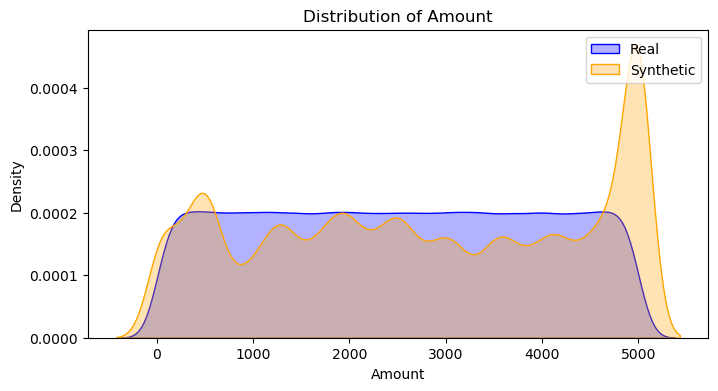

/home/trusted-service-user/cluster-env/clonedenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/clonedenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


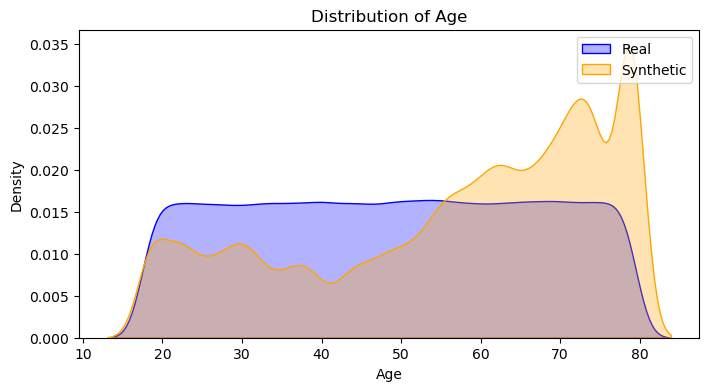

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------
# 1️⃣ Prepare Real Data
# -----------------------------
real_data = masked_df.limit(200_000).toPandas()

# Convert and extract features
real_data['TransactionDate'] = pd.to_datetime(real_data['TransactionDate'], errors='coerce')
real_data['DayOfWeek'] = real_data['TransactionDate'].dt.dayofweek
real_data['Month'] = real_data['TransactionDate'].dt.month
real_data = real_data.drop(columns=['TransactionDate', 'CustomerHash'])

# -----------------------------
# 2️⃣ Prepare Synthetic Data
# -----------------------------
# If synthetic_data is Spark DF
synthetic_data = synthetic_data.head(200_000) if not isinstance(synthetic_data, pd.DataFrame) else synthetic_data

# Ensure correct column types
for col in ['Age', 'Amount']:
    if col in synthetic_data.columns:
        synthetic_data[col] = pd.to_numeric(synthetic_data[col], errors='coerce')
        real_data[col] = pd.to_numeric(real_data[col], errors='coerce')

# -----------------------------
# 3️⃣ Define Plotting Function
# -----------------------------
def plot_column_distribution(real_data, synthetic_data, column):
    plt.figure(figsize=(8, 4))
    
    # Drop NaNs to avoid plotting issues
    real_series = real_data[column].dropna()
    synth_series = synthetic_data[column].dropna()

    # Plot densities
    sns.kdeplot(real_series, label='Real', fill=True, color='blue', alpha=0.3)
    sns.kdeplot(synth_series, label='Synthetic', fill=True, color='orange', alpha=0.3)
    
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# -----------------------------
# 4️⃣ Plot Example Columns
# -----------------------------
plot_column_distribution(real_data, synthetic_data, 'Amount')
plot_column_distribution(real_data, synthetic_data, 'Age')


StatementMeta(, dcbd4c3a-06a8-4d4c-ba7a-460466f70e81, 11, Finished, Available, Finished)

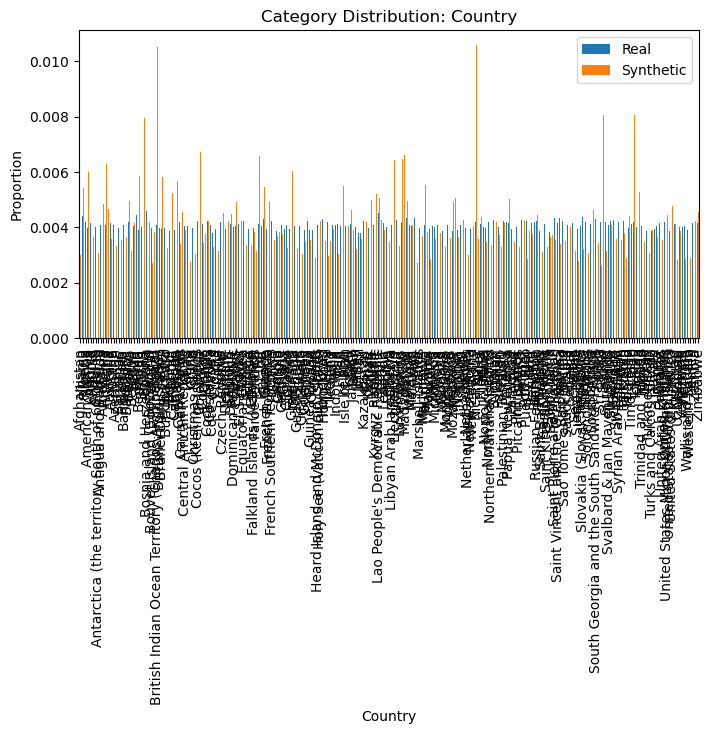

In [ ]:
def plot_categorical_counts(real_data, synthetic_data, column):
    real_counts = real_data[column].value_counts(normalize=True)
    synth_counts = synthetic_data[column].value_counts(normalize=True)
    compare_df = pd.DataFrame({'Real': real_counts, 'Synthetic': synth_counts}).fillna(0)

    compare_df.plot(kind='bar', figsize=(8,4))
    plt.title(f'Category Distribution: {column}')
    plt.ylabel('Proportion')
    plt.show()

# Example usage
plot_categorical_counts(sample_data, synthetic_data, 'Country')

StatementMeta(, dcbd4c3a-06a8-4d4c-ba7a-460466f70e81, 12, Finished, Available, Finished)

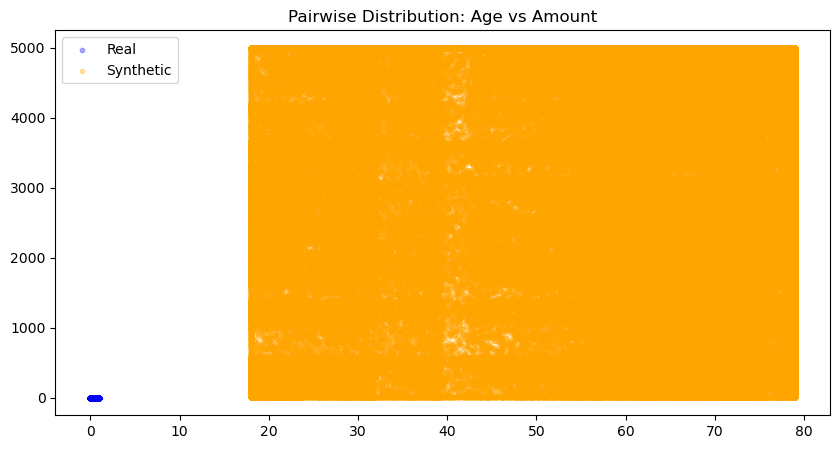

In [ ]:
def plot_pairwise_scatter(real_data, synthetic_data, col_x, col_y):
    plt.figure(figsize=(10,5))
    plt.scatter(real_data[col_x], real_data[col_y], alpha=0.3, label='Real', s=10, c='blue')
    plt.scatter(synthetic_data[col_x], synthetic_data[col_y], alpha=0.3, label='Synthetic', s=10, c='orange')
    plt.title(f'Pairwise Distribution: {col_x} vs {col_y}')
    plt.legend()
    plt.show()

plot_pairwise_scatter(sample_data, synthetic_data, 'Age', 'Amount')

StatementMeta(, dcbd4c3a-06a8-4d4c-ba7a-460466f70e81, 13, Finished, Available, Finished)

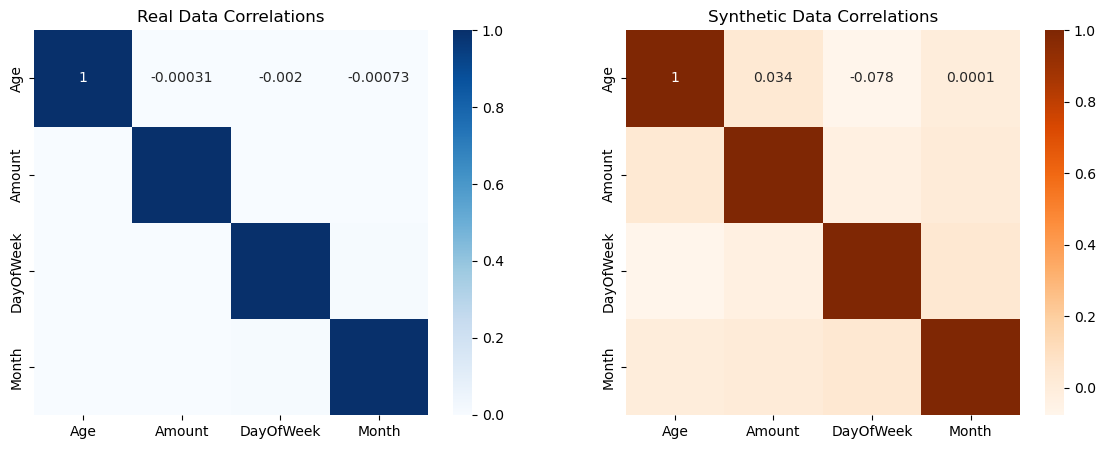

In [ ]:
def plot_correlation_heatmaps(real_data, synthetic_data):
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    sns.heatmap(real_data.corr(), ax=axes[0], cmap='Blues', annot=True)
    axes[0].set_title('Real Data Correlations')
    sns.heatmap(synthetic_data.corr(), ax=axes[1], cmap='Oranges', annot=True)
    axes[1].set_title('Synthetic Data Correlations')
    plt.show()

plot_correlation_heatmaps(sample_data.select_dtypes(include='number'), 
                          synthetic_data.select_dtypes(include='number'))